# Multivariate statistics Test 6: EFA + CA

**Student**: Aleksandr Jan Smoliakov, VU MIF Data Science MSc year 1  
**Date**: 2024-12-05

## Exploratory Factor Analysis

Data: File `Beer.sav`, variables

* `cost`
* `size`
* `alcohol`
* `color`
* `aroma`
* `taste`

Task: perform factor analysis.

First of all, let's load the data and take a look.

In [ ]:
import numpy as np
import pandas as pd
import pyreadstat
from factor_analyzer import FactorAnalyzer, calculate_kmo
from matplotlib import pyplot as plt

pd.options.display.float_format = '{:.4f}'.format

df_beer, metadata_beer = pyreadstat.read_sav("data/Beer.sav")

df_beer.describe()

,COST,SIZE,ALCOHOL,REPUTAT,COLOR,AROMA,TASTE,SES,GROUP
count,231.0000,231.0000,231.0000,231.0000,231.0000,220.0000,231.0000,231.0000,231.0000
mean,48.8095,45.7143,49.0476,48.3333,49.5238,44.7500,65.9524,3.3333,1.4286
std,34.1574,34.3800,33.4755,23.6214,27.0465,25.8209,24.2353,2.5378,0.4959
min,0.0000,0.0000,10.0000,0.0000,0.0000,0.0000,25.0000,0.0000,1.0000
25%,15.0000,15.0000,20.0000,30.0000,30.0000,27.5000,50.0000,2.0000,1.0000
50%,50.0000,35.0000,35.0000,40.0000,50.0000,45.0000,65.0000,3.0000,1.0000
75%,80.0000,80.0000,70.0000,65.0000,75.0000,66.2500,90.0000,5.0000,2.0000
max,100.0000,100.0000,100.0000,100.0000,95.0000,90.0000,100.0000,8.0000,2.0000


There are 11 missing values in the `aroma` column. We are going to remove them.

The dataset has three additional columns not described in the task: `reputat`, `ses` and `group`. We are not going to remove them to avoid using them accidentally.

In [49]:
df_beer = df_beer.drop(["REPUTAT", "SES", "GROUP"], axis=1)
df_beer = df_beer.dropna()
df_beer.columns = df_beer.columns.str.lower()

df_beer

,cost,size,alcohol,color,aroma,taste
0,90.0000,80.0000,70.0000,50.0000,70.0000,60.0000
1,75.0000,95.0000,100.0000,55.0000,40.0000,65.0000
2,10.0000,15.0000,20.0000,40.0000,30.0000,50.0000
3,100.0000,70.0000,50.0000,75.0000,60.0000,80.0000
4,20.0000,10.0000,25.0000,30.0000,35.0000,45.0000
...,...,...,...,...,...,...
225,20.0000,5.0000,10.0000,60.0000,50.0000,95.0000
226,70.0000,60.0000,70.0000,10.0000,15.0000,25.0000
227,50.0000,15.0000,20.0000,10.0000,5.0000,50.0000
228,75.0000,50.0000,95.0000,0.0000,0.0000,40.0000


### KMO

We are going to calculate the KMO measure of adequacy to check if the data is suitable for factor analysis (i.e. KMO > 0.5).

In [57]:
kmo_all, kmo_model = calculate_kmo(df_beer)
print(f"KMO Model: {kmo_model:.3f}")

KMO Model: 0.628


The KMO of 0.628 is acceptable.

### Variance explained by factors

Variance explained by each factor is shown in the table below.

In [163]:
ev, v = np.linalg.eig(df_beer.corr())
ev = ev / ev.sum()
ev = np.sort(ev)[::-1]
ev

array([0.4781151 , 0.43414613, 0.04000927, 0.02392752, 0.01761521,
       0.00618677])

In [164]:
df_var_explained = pd.DataFrame(
    {
        "factor": range(1, 7),
        "eigenvalues": ev,
        "proportion": ev / ev.sum(),
        "cumulative": np.cumsum(ev / ev.sum()),
    }
)

In [165]:
df_var_explained

,factor,eigenvalues,proportion,cumulative
0,1,0.4781,0.4781,0.4781
1,2,0.4341,0.4341,0.9123
2,3,0.0400,0.0400,0.9523
3,4,0.0239,0.0239,0.9762
4,5,0.0176,0.0176,0.9938
5,6,0.0062,0.0062,1.0000


### Scree plot

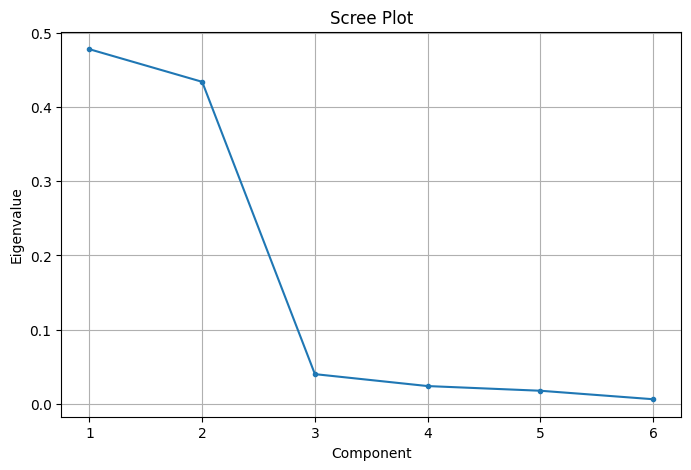

In [166]:
plt.figure(figsize=(8, 5))
plt.plot(
    df_var_explained["factor"],
    df_var_explained["eigenvalues"],
    marker=".",
    label="Eigenvalues",
)
plt.title("Scree Plot")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.grid()
plt.show()

Based on the above table and plot we're going to choose 2 factors with eigenvalues > 1. Cumulatively they explain 91.2% of the variance (see table above).

In [167]:
n_factors = 2

### Communalities

The table below shows the communalities of the variables. All of them are above 0.2, which is acceptable.

In [191]:
fa = FactorAnalyzer(rotation="varimax", method="principal", n_factors=n_factors)
fa.fit(df_beer)

communalities = fa.get_communalities()
pd.DataFrame(communalities, index=df_beer.columns, columns=["Communalities"])

,Communalities
cost,0.8458
size,0.9430
alcohol,0.8911
color,0.9499
aroma,0.9236
taste,0.9201


### Total variation explained by extracted factors

We will confirm that the total variation explained by the two extracted factors is still 91.2%.

In [192]:
df_var_explained = pd.DataFrame(
    np.transpose(fa.get_factor_variance()),
    columns=["eigenvalues", "proportion", "cumulative"],
)
df_var_explained.insert(0, "factor", range(1, 3))
df_var_explained

,factor,eigenvalues,proportion,cumulative
0,1,2.7960,0.4660,0.4660
1,2,2.6776,0.4463,0.9123


### Rotated factor solution

The rotated factor loadings are shown in the table below.

In [193]:
df_loadings = pd.DataFrame(fa.loadings_, index=df_beer.columns)
df_loadings.columns = [f"Factor {i}" for i in range(1, n_factors + 1)]
df_loadings

,Factor 1,Factor 2
cost,-0.0648,0.9174
size,0.0787,0.9679
alcohol,0.0189,0.9438
color,0.9708,0.0856
aroma,0.9608,0.0230
taste,0.9590,-0.0228


### Variables related to each factor and Factor names

Based on the loadings provided above, we can see the following:

The first factor is strongly related to `color`, `aroma`, and `taste` with loadings > 0.9, all of them positively correlated. Based on that, we will interpret the first factor as the "taste" factor.

The second factor is strongly related to `cost`, `size`, and `alcohol` with loadings > 0.9, all of them positively correlated. Based on that, we will interpret the second factor as the "size" factor.

Thus, we have two factors:
* "taste" factor, positively related to `color`, `aroma`, and `taste`
* "size" factor, positively related to `cost`, `size`, and `alcohol`

## Correspondence Analysis

Data: Dataframe below

* `lib`: liberal
* `slib`: slightly liberal
* `mod`: moderate
* `scon`: slightly conservative
* `con`: conservative

Task: perform correspondence analysis.

In [289]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency

In [202]:
df_politics = pd.DataFrame(
    {
        "Protestant": [98, 116, 324, 163, 214],
        "Catholic": [33, 40, 139, 61, 52],
        "Jewish": [9, 6, 7, 5, 3],
        "None": [41, 28, 43, 16, 7],
    },
    index=["lib", "slib", "mod", "scon", "con"],
)

df_politics

,Protestant,Catholic,Jewish,None
lib,98,33,9,41
slib,116,40,6,28
mod,324,139,7,43
scon,163,61,5,16
con,214,52,3,7


### Chi-square test

In [222]:
chi2_result = chi2_contingency(df_politics)
print(f"Chi-Square Statistic: {chi2_result.statistic:.3f}")
print(f"p-value: {chi2_result.pvalue}")
print(f"Degrees of Freedom: {chi2_result.dof}")
print("Expected Frequencies:")
pd.DataFrame(chi2_result.expected_freq, columns=df_politics.columns, index=df_politics.index)

Chi-Square Statistic: 84.434
p-value: 5.8455426657118e-13
Degrees of Freedom: 12
Expected Frequencies:


,Protestant,Catholic,Jewish,None
lib,117.8754,41.8683,3.8648,17.3915
slib,123.7367,43.9502,4.0569,18.2562
mod,334.0890,118.6655,10.9537,49.2918
scon,159.5552,56.6726,5.2313,23.5409
con,179.7438,63.8434,5.8932,26.5196


The Chi-square test is significant (p < 0.05), so we can proceed with correspondence analysis.

### Eigenvalues and cumulative variance explained by 2 dimensions

We are going to perform SVD on the contingency table and calculate the eigenvalues and the cumulative variance explained by 2 dimensions.

In [300]:
residuals = (df_politics - chi2_result.expected_freq) / np.sqrt(chi2_result.expected_freq)
total = df_politics.values.sum()

svd_result = np.linalg.svd(residuals, full_matrices=False)

ev = svd_result.S**2 / (total * np.min(df_politics.shape))
cumulative_var = np.cumsum(ev / ev.sum())

pd.DataFrame(
    {
        "Dimension": range(1, 5),
        "Eigenvalues": ev,
        "Cumulative Variance": cumulative_var,
    }
).iloc[:2]

,Dimension,Eigenvalues,Cumulative Variance
0,1,0.0131,0.8706
1,2,0.0019,0.9944


The first two dimensions explain 99.44% of the variance.

### Vizualization (biplot)

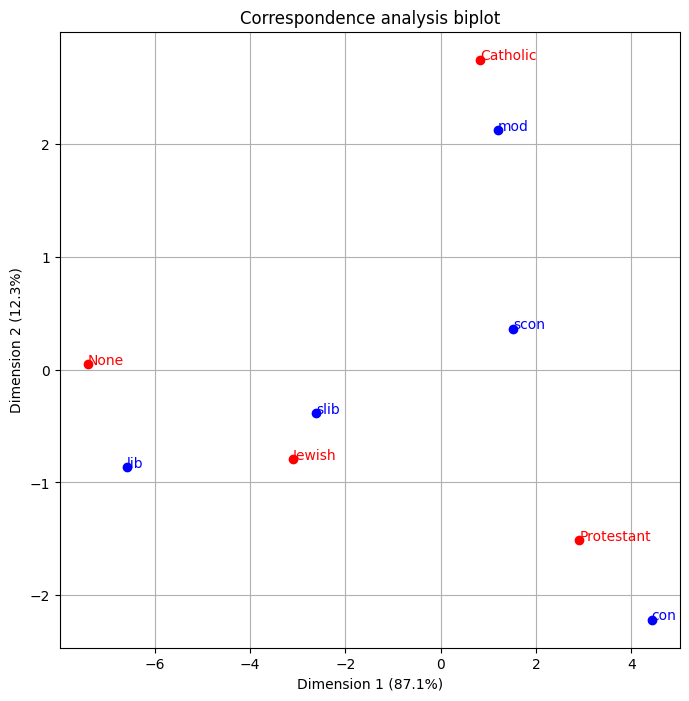

In [328]:
row_coordinates = svd_result.U[:, :2] @ np.diag(svd_result.S[:2])
col_coordinates = svd_result.Vh[:2].T @ np.diag(svd_result.S[:2])

plt.figure(figsize=(8, 8))

for i, (x, y) in enumerate(row_coordinates):
    plt.scatter(x, y, color="blue")
    plt.text(x, y, df_politics.index[i], color="blue")

for i, (x, y) in enumerate(col_coordinates):
    plt.scatter(x, y, color="red")
    plt.text(x, y, df_politics.columns[i], color="red")

plt.title("Correspondence analysis biplot")
plt.xlabel("Dimension 1 (87.1%)")
plt.ylabel("Dimension 2 (12.3%)")
plt.grid()
plt.show()

Comments:

* Political views and religions close together are strongly associated.
* Catholics appear to have a tendency to be moderate, Protestants tend to be conservative, Jewish people tend to be slightly liberal, and atheists tend to be liberal.